# ICA on Ensemble of 1D Fields

<b>Import modules</b>

In [1]:
# %load_ext autoreload

In [1]:
import importlib as il
import copy

from pathlib import Path # For path manipulations and module loading
import numpy as np
import matplotlib.pyplot as plt # plt.rcParams.update({'font.size': 12})
# import matplotlib.gridspec as grd
import pickle

import scipy.interpolate as interpolate
import scipy.signal as signal
import scipy.stats as stats
from scipy.signal.windows import hann

# Independent Component Analysis
# sklearn module contains contains a FastICA capability. We can chose the cost function (measure of non-Gaussianity): 
# cube for kurtosis and logcosh for negentropy approximation.
from sklearn.decomposition import FastICA

# import nbodykit.lab as nbkt
import modules.jaafar_peaks as px
import modules.jaafar_fouriertransform as ft
import modules.jaafar_correlationfunctions as cf

import modules.fields_gauss as grf
import modules.fields_nong as nong
import modules.filters as flt
import modules.ica as ica
import modules.helpers as helper
from modules.helpers import resid

zeta multiplication factor = { (2*\pi*sidelength)/(sidelength_in_mpc) }^3

peak-patch/tools/powerspectrum_create

pkp/tables/planck18_intermittent.dat
(1st column -- k; 2nd -- delta_delta power spectrum; 3rd -- zeta transfer func/k^2)
zeta power spectrum = 2nd col / 3rd^2

tables/plot_spectra.py line 142

zeta = zeta(g)

take flat GRF power spectrum, multiply by sqrt[ (2*\pi*N / N_in_Mpc)^3 {power spectra above} ].

will have real-space zeta(x) = zeta_g + fnl*chi^2

Hann Window: 

w(n) = 0.5 - 0.5 * cos( (2 * pi * n) / (M-1) )     

[0 <= n <= M - 1]

## Generate Primodial $\zeta$ Fields

In [2]:
def grf_ensemble(N_ensemble, N_field, A0=7.96*10**-10, ns=1.0, kmnr=2/3, ensemble_seeds=None):
    """

    """

    ensemble = np.zeros((N_ensemble, N_field))
    N = N_field

    if ensemble_seeds is None:
        seeds = np.zeros(N_ensemble)
        for i in range(N_ensemble):
            seeds[i] = np.random.get_state()
    else:
        seeds = ensemble_seeds

    for i in range(N_ensemble):
        np.random.set_state(seeds[i])

        zg = grf.grf_zeta_1d(N, pk_amp=A0, pk_ns=ns, kmaxknyq_ratio=kmnr, seed=seeds[i])
        ensemble[i, :] = zg

    return ensemble, seeds

def chisq_ensemble(N_ensemble, N_field, Achi=10**(-10), Rchi=0.04, Bchi=0.0, Fng=1.0, kmnr=2/3, ensemble_seeds=None):
    """

    """

    ensemble = np.zeros((N_ensemble, N_field))
    N = N_field

    if ensemble_seeds is None:
        seeds = np.zeros(N_ensemble)
        for i in range(N_ensemble):
            seeds[i] = np.random.get_state()
    else:
        seeds = ensemble_seeds

    for i in range(N_ensemble):
        np.random.set_state(seeds[i])

        zng_chisq = nong.nong_chisq(N, Achi, Rchi, Bchi, Fng, kmnr, seedchi=seeds)
        ensemble[i, :] = zng_chisq

    return ensemble, seeds

### Gaussian Random Fields:
<b>Set parameters and initialize the $\zeta$ GRFs.</b>

In [2]:
#
# GRF Parameters
#
N_ensemble = 4
logtwo_N = 2; N_field = N = 2**logtwo_N # Field size (points/pixels)
A0 = (7.96*10**-10)# * 2*np.pi**2) # Amplitude
ns = 1.0 # Spectral tilt
# A0 = 1.0 # Amplitude
# ns = 0.965 # Spectral tilt
kmnr = 2/3 # Ratio of max (cut-off) k-freq to the Nyquist k-freq

seeds = np.zeros(N_ensemble)
for i in range(N_ensemble):
    seeds[i] = np.random.get_state()
zg = grf.grf_zeta_1d(N, pk_amp=A0, pk_ns=ns, kmaxknyq_ratio=kmnr, seed=seeds)
#
# Generate the GRF ensembles
#
# zg_ensemble, seeds_zg = grf_ensemble(N_ensemble, N_field, A0=7.96*10**-10, ns=1.0, kmnr=2/3, ensemble_seeds=None)




/fs/lustre/scratch/RAID-CITA/haider/projects/pnong_ml/ica/modules/fields_gauss.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.random.seed(seed)


TypeError: Cannot cast array data from dtype('O') to dtype('int64') according to the rule 'safe'

In [ ]:


#
# NON-G CHI_e^2 Parameters
#
# from nate:
# Achi = 1.6*10**(-19)
# Rchi = 0.64
# Bchi = ?
#
Achi = 10**(-10)
Rchi = 0.04
# Bchi = 10**(-13)
Bchi = 0.0
Fng = 0.7 # Instead of FNL

#
# Generate the CHI_e^2 NON-G ensembles
#
zng_ensemble, seeds_zng = chisq_ensemble(N_ensemble, N_field, Achi=10**(-10), Rchi=0.04, Bchi=0.0, Fng=1.0, kmnr=2/3, ensemble_seeds=None)





#
# Final non-Gaussian Zeta field & the seeds used to generate the fields.
#
z_ensemble = zg_ensemble + zng_ensemble
ensemble_seeds = np.array(seeds_zg, seeds_zng)

### Non-Gaussian Components of Fields:
<b>Set parameters and initialize the non-Gaussian components that will be added to the $\zeta$ GRFs.</b>

#### $\Chi_e^2$ non-Gaussianity

### Final Non-Gaussian Fields:
<b>Create the final, non-Gaussian $\zeta$ fields using the simulated GRF + the simulated non-G component.</b>

Note that 'zg1' is the field used to generate the NG component called 'ng_asymsinh'. 
So the 'zng_asymsinh' is correlated with 'zg1' but uncorrelated with 'zg2', a different Gaussian random field.
The final $\zeta$ field will be generated depending on the choice of 'correlation' (or lack thereof).

The 'ng_chisq' non-G component is uncorrelated to both 'zng1' and 'zng2'

### Tests

In [ ]:
"""
Same plots as above
"""
idxg = 0
idxng = 0
zg = zg_ensemble[idxg, :]
zng = zng_ensemble[idxng, :]

fontsize = 5

fig, ax = plt.subplots(3, 1,  sharex=True, sharey=True, figsize=(8,10))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Amplitude")
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
# Original NG component
ax[0].plot(zg)
ax[1].plot(zng, color='C1')
ax[2].plot(zng + zg, color='C2')
ax[2].xaxis.set_tick_params(labelbottom=True)
plt.xlabel(r'$x$')

fig.tight_layout()
fig.subplots_adjust(hspace=0)

plt.text(0.94, 0.95, r'$\zeta_G$', fontsize=fontsize, horizontalalignment='right')
plt.text(0.94, 0.62, r'$\zeta_{NG}$', fontsize=fontsize, horizontalalignment='right')
plt.text(0.94, 0.28, r'$\zeta_G + \zeta_{NG}$', fontsize=fontsize, horizontalalignment='right')

# if correlated:
#     plt.savefig('ICA_corr_sources.png')
# else:
#     plt.savefig('ICA_uncorr_sources.png')

### Plot the sources

Text(0.94, 0.28, '$\\zeta_{G2}+\\zeta_{NG_1}$')

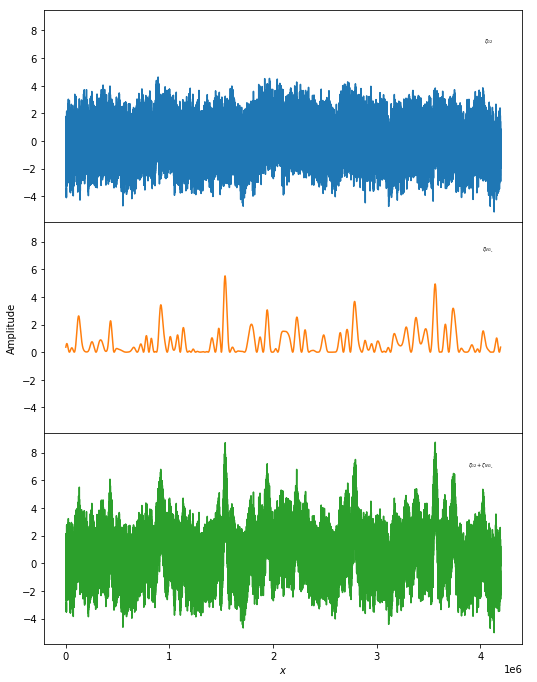

## <u>Apply ICA to 1D-Ensemble</u>
<b> For fully determined ICA separation.
<br>
Sklearn's implementation does not allow for underdetermined separation. </b>

### Setup

### FastICA Test Run

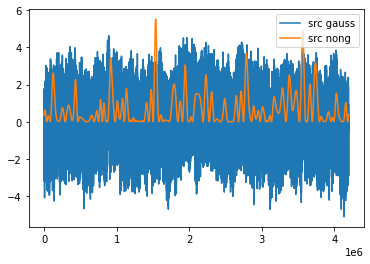

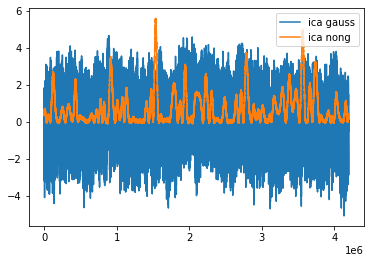

In [5]:
#
#
# ICA parameters/vars
#
#
max_iter = int(5e10)
tol = 1e-13
prewhiten = False
wbin_size = None

#
#
# Run ICA
#
#
src, ica_src, max_amps, mix_signals, ica_src_og = ica.ica_all(zg, zng, 
                                            max_iter=max_iter, tol=tol,
                                                prewhiten = prewhiten, wbin_size = wbin_size)
                                    
mix_signal_pre, mix_signal = mix_signals[0,:], mix_signals[1,:]



# plt.plot(mix_signal_pre[0, :], label='signal mixture 1')
# plt.legend(loc=1)
# plt.show()

# plt.plot(mix_signal[0, :], label='bin-whitened signal mixture 1')
# plt.legend(loc=1)
# plt.show()


plt.plot(src[1, :], label='src gauss')
plt.plot(src[0, :], label='src nong')
plt.legend(loc=1)
plt.show()

plt.plot(ica_src[1, :], label='ica gauss')
plt.plot(ica_src[0, :], label='ica nong')
plt.legend(loc=1)
plt.show()

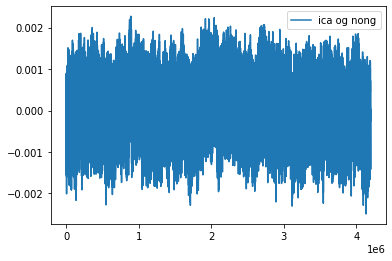

0.38529215509200254


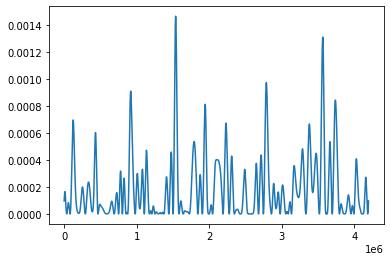

In [6]:
# plt.plot(src[1, :], label='src gauss')
plt.plot(ica_src_og[1, :], label='ica og nong')
plt.legend(loc=1)
plt.show()

a = src[0, :]
b = ica_src[0, :]
rr, rv = resid(a, b)
print(rr)

# a = src[1, :]
# b = ica_src[1, :]
# rv, r, rr = resid(a, b)
# print(r, rr)

plt.plot(rv)
plt.show()

### Apply Sklearn's $\texttt{FastICA}$

In [7]:
nkbins = 10
max_iter = int(5e9)
tol = 1e-10
fun='logcosh'
whiten='unit-variance'
algo='parallel'
prewhiten = False
kmin=int(0)
kmin=None
kmax=N//4
kmax=int(200)
kmnr = kmnr
dc=False

src, ica_src, kbins, max_amps, fzkt, zkt, hannf, ica_src_og = flt.filterhann_ica(zg, zng, k_min=kmin, k_max=kmax, kmaxknyq_ratio=kmnr, nkbins=nkbins, dc=dc, 
                                                                max_iter=max_iter, tol=tol, fun='logcosh', whiten='unit-variance', algo='parallel', 
                                                                prewhiten = False)

Processing unfiltered field...
Swapped!
NonG sign flipped!
[  0  22  44  67  89 111 133 156 178 200]
[  0  22  44  67  89 111 133 156 178 200]
Processing k-bin number:    1 ...
Swapped!
Processing k-bin number:    2 ...
NonG sign flipped!
Processing k-bin number:    3 ...
NonG sign flipped!
Processing k-bin number:    4 ...
NonG sign flipped!
Processing k-bin number:    5 ...
NonG sign flipped!
Processing k-bin number:    6 ...
Swapped!
Processing k-bin number:    7 ...
NonG sign flipped!
Processing k-bin number:    8 ...
Processing k-bin number:    9 ...
NonG sign flipped!
Processing k-bin number:    10 ...


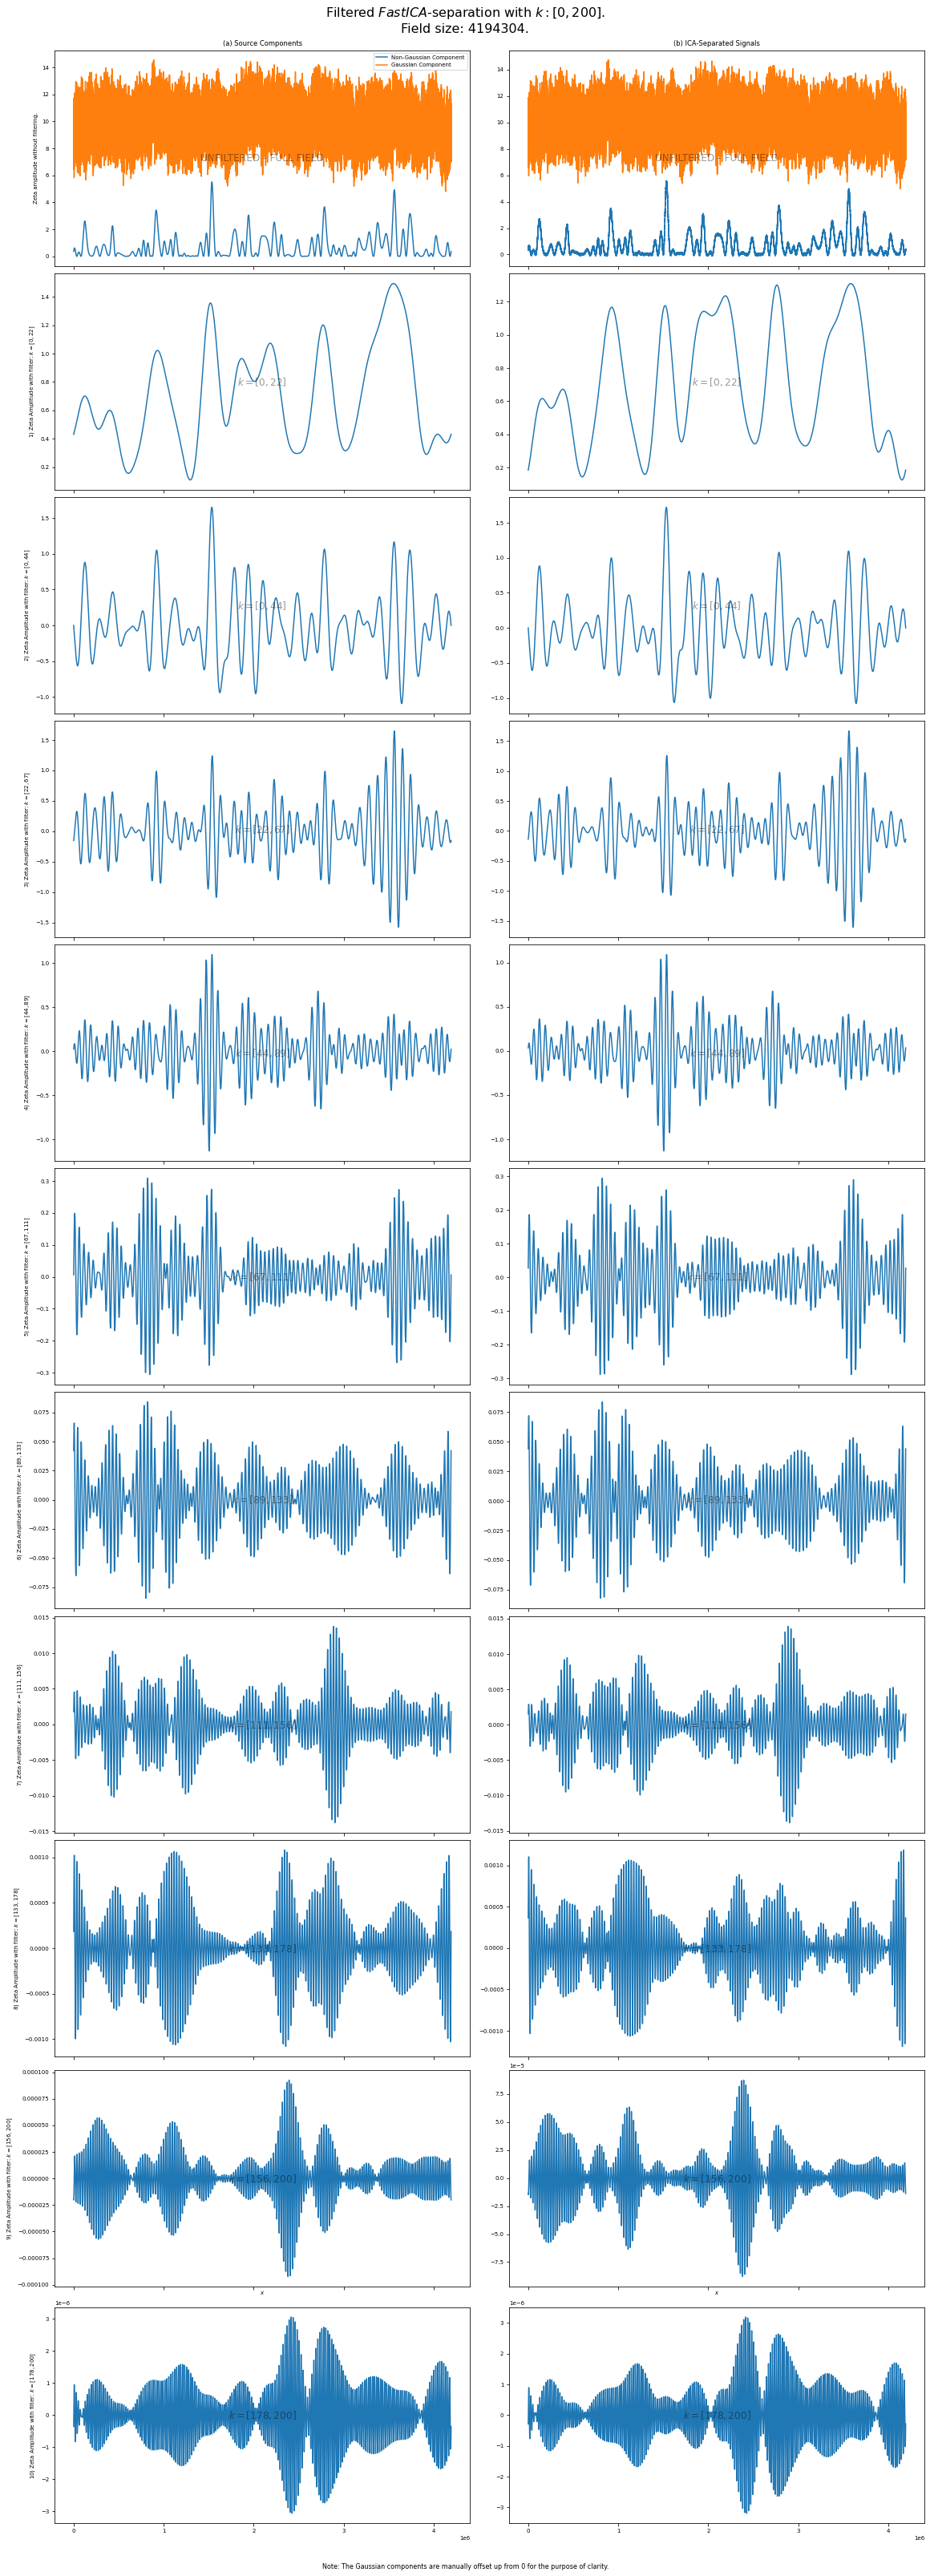

In [8]:
helper.plt_icaflt(src, ica_src, kbins, max_amps, fontsize=7)

0.3561935568154091


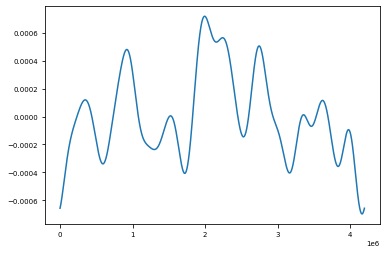

In [9]:
rr, rv = resid(src[1, 1, :], ica_src[1, 1, :])
print(rr)
plt.plot(rv)

In [11]:

# def plt_filters(N, kc, fzkt, zkt, hannf, fontsize=7):
#     """

#     """

#     fzkt = np.abs(fzkt) / N
#     zkt = np.abs(zkt) / N

#     Nk = fzkt.shape[2]
#     nkbins = fzkt.shape[0]
#     ncomps = fzkt.shape[1]

#     #
#     #
#     # Plot
#     #
#     #
#     plt.rcParams.update({'font.size': fontsize})
#     nrows = nkbins + 1
#     ncols = 2

#     fig, ax = plt.subplots(nrows, 1, sharex='all', figsize=(8, 4*nrows), constrained_layout=True)

#     ax0 = ax[0]
#     for i in range(nkbins):
#         # if i == 0:
#         #     klow = kc[i]
#         #     khigh = kc[i+1]
#         # elif i < nkbins-1:
#         #     klow = kc[i-1]
#         #     khigh = kc[i+1]
#         # else:
#         #     klow = kc[i-1]
#         #     khigh = kc[i]
            
#         if i < nkbins-1:
#             axx = ax[0].twinx()
#             color = 'tab:red'
#             axx.plot(np.nonzero(hannf[i, :])[0], hannf[i, hannf[i, :]!=0], color=color, alpha=0.4)
#             axx.tick_params(axis='y', labelcolor=color)
#             axx.tick_params(
#                 axis='y',           # changes apply to the y-axis
#                 which='both',       # both major and minor ticks are affected
#                 right=False,        # ticks along the right edge are off
#                 labelright=False)   # labels along the right edge are off
#         else:
#             axx = ax[0].twinx()
#             color = 'tab:red'
#             label = "Hann window"
#             axx.plot(hannf[i, :], label=label, color=color, alpha=0.4)
#             axx.tick_params(axis='y', labelcolor=color)
#             axx.set_ylabel('Window Amplitude', color=color)
#             axx.legend(loc=1)
    
#     ax[0].set_title("Unfiltered k-frequencies with Hann")
#     label = "k-frequencies"
#     ax[0].plot(zkt[0, :], label=label)
#     ax[0].set(ylabel="k-amplitude (unfiltered)")
#     ax[0].legend(loc=2)

#     ax[0].text(0.5, 0.5, "UNFILTERED K-FREQUENCIES", 
#                     fontsize='xx-large', transform=ax[0].transAxes, 
#                         ha='center', va='center', alpha=0.4)

#     ax[1].set_title("Filtered k-frequencies with Hann")
#     for i in range(nkbins):
#         count = i+1
#         if i == 0:
#             klow = kc[i]
#             khigh = kc[i+1]
#         elif i < nkbins-1:
#             klow = kc[i-1]
#             khigh = kc[i+1]
#         else:
#             klow = kc[i-1]
#             khigh = kc[i]

#         klow = round(klow, 0); khigh = round(khigh, 0)


#         axx = ax[count].twinx()
#         color = 'tab:red'
#         axx.set_ylabel('Window Amplitude', color=color)
#         label = "Hann window"
#         axx.plot(hannf[i, :], label=label, color=color)
#         axx.tick_params(axis='y', labelcolor=color)
#         axx.legend(loc=1)

#         # ax[count, 0].sharey(ax00)
#         label = "k-frequencies"
#         ax[count].plot(fzkt[i, 0, :], label=label)
#         ax[count].set(ylabel=f'{count}) ' + "k amplitude with filter: " + r"$k=[{{{kl}}}, {{{kh}}}]$".format(kl=klow, kh=khigh))
#         ax[count].legend(loc=2)
        

#         ax[count].text(0.5, 0.5, r"$k=[{{{kl}}}, {{{kh}}}]$".format(kl=klow, kh=khigh), 
#                                 fontsize='xx-large', transform=ax[count].transAxes, 
#                                     ha='center', va='center', alpha=0.4)

#     ax_count = nkbins
#     ax[ax_count].set(xlabel=r'$k$')

#     fig.suptitle(rf'Hann window-filtering in Fourier-domain with $k: [{{{kc[0]}}}, {{{kc[-1]}}}]$.' + f'\nField size: {N}.', fontsize=16)

#     plt.savefig(f'/fs/lustre/cita/haider/projects/pnong_ml/ica/plots/icafiltered/chie2/chie2_hann_s{N}_{int(kbins[0])}to{int(kbins[-1])}k{nkbins}.png', facecolor='white', bbox_inches='tight')
#     # note="Note: The Gaussian components are manually offset up from 0 for the purpose of clarity."
#     # fig.text(0.5, -0.01, note, wrap=True, horizontalalignment='center', fontsize=8)
#     plt.show()

#     return

[  0  22  44  67  89 111 133 156 178 200]
(10, 2, 200)
[]
[]


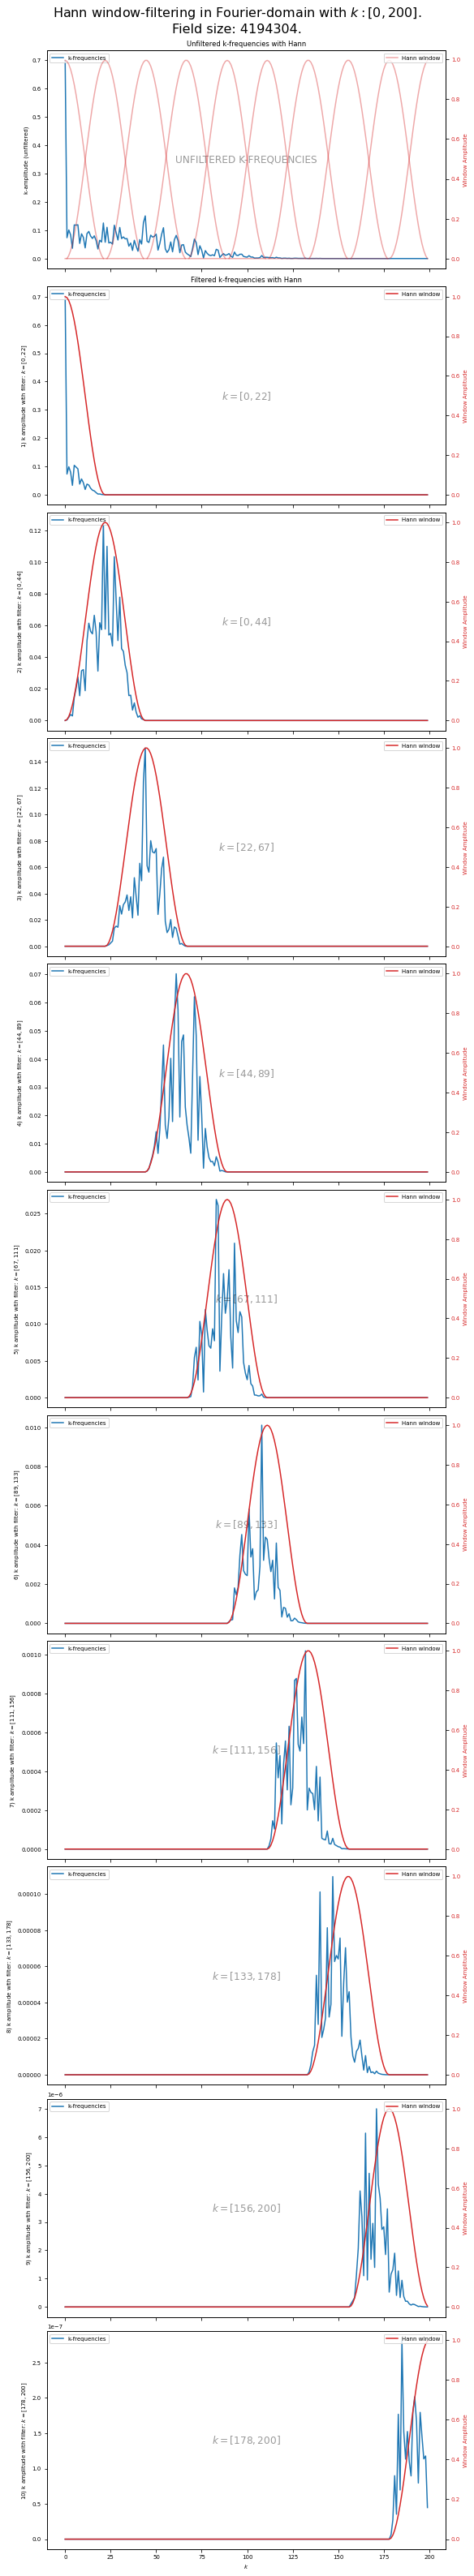

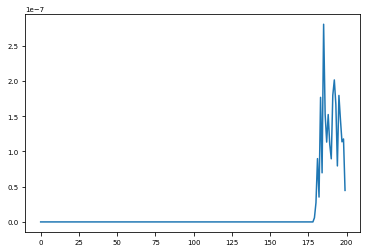

In [12]:
print(kbins)
print(fzkt.shape)
print(np.abs(fzkt[9, 0, 222:230])/N)
print(hannf[9, 222:230])
helper.plt_filters(N, kbins, fzkt, zkt, hannf, fontsize=7)
plt.plot(np.abs(fzkt[9, 0, :])/N) 

In [13]:
# f = 1
# xmax = 10
# s = 1000
# x = np.linspace(0, xmax, int(xmax*s))
# # y = np.sin(2 * np.pi * f * x)
# y = np.sin(2 * np.pi * f * x)+1
# print(y.size)
# testft = np.fft.rfft(y)
# testft[0] = 0
# testftabs = np.abs(np.fft.rfft(y))
# testftfreq = np.fft.rfftfreq(y.size, d=1./s)
# iy = np.fft.irfft(testft, len(y))
# print(iy.size)
# print(testftfreq.size)
# plt.plot(x, y)
# plt.show()
# plt.plot(testftfreq, testftabs)
# plt.xlim(0,10)
# plt.show()
# plt.plot(x, iy)
# plt.show()

In [15]:
# n = 100
# h1, h2, h3 = 0, 50, 100
# domain = np.arange(0, n)

# hann1 = np.zeros(n)
# hann2 = np.zeros(n)
# hann3 = np.zeros(n)

# hann1[h1:h2] = hann(n, False)[h2:h3]
# hann2[h1:h3] = hann(n, False)
# hann3[h2:h3] = hann(n, False)[h1:h2]
# hannsum = hann1+hann2+hann3

In [16]:
# print(hann2.size)
# print(hann2[-1])
# print(hann2)

In [17]:
# plt.scatter(domain, hann1)
# plt.scatter(domain, hann2)
# plt.scatter(domain, hann3)
# plt.scatter(domain, hannsum)

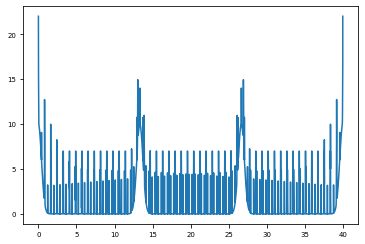

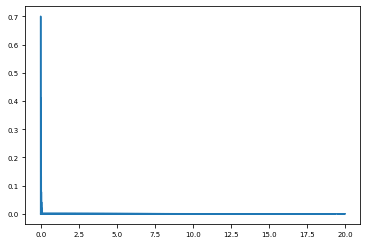

In [18]:
npks = 50
npkshk = int(100)

w = 0.01
whk = w/500

xrange = 40
n = 500000
samplerate = xrange/n

aPeak1 = np.full(npks, 7)
aPeak2 = np.full(10, 10)
aPeak3 = np.full(npkshk, 5)

xPeak1 = np.linspace(-10, 10, npks)
xPeak2 = np.linspace(-10, 10, 4)
xPeak3 = np.linspace(-10, 10, npkshk)

wPeak1 = np.full(npks, w)
wPeak2 = np.full(5, w*20)
wPeak3 = np.full(npkshk, whk)

rv = np.linspace(-10, 10, n)
pks1 = np.sum(np.array([ac*np.exp(-0.5*(rv-xc)**2/wc**2) for ac,xc,wc in zip(aPeak1,xPeak1,wPeak1)]), axis=0) # Peaks as separate source signals
pks2 = np.sum(np.array([ac*np.exp(-0.5*(rv-xc)**2/wc**2) for ac,xc,wc in zip(aPeak2,xPeak2,wPeak2)]), axis=0) # Peaks as separate source signals
pks3 = np.sum(np.array([ac*np.exp(-0.5*(rv-xc)**2/wc**2) for ac,xc,wc in zip(aPeak3,xPeak3,wPeak3)]), axis=0) # Peaks as separate source signals
tst = np.sum([pks1, pks2, pks3], axis=0) # Peaks as separate source signals
x = np.linspace(0, xrange, n)

plt.plot(x, tst)
plt.show()

tstfft = np.abs(np.fft.rfft(tst))
tstk = np.fft.rfftfreq(n, d=1./samplerate)*n

plt.plot(tstk[4:], (tstfft/n)[4:])
# plt.xlim(0.01, 5)
plt.show()

In [19]:
yy = np.fft.irfft(tstfft)

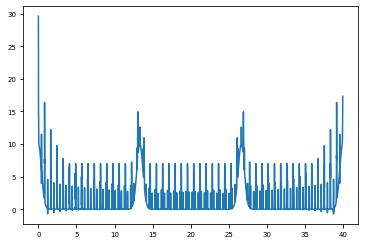

In [20]:
plt.plot(x, yy)
plt.show()

[     0 125000 250001]
(3, 500000)


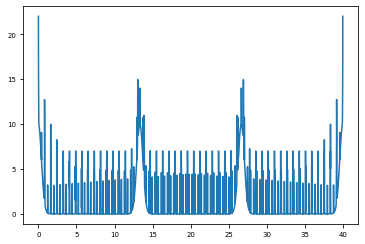

In [21]:
filtt, k, _, _, _ = flt.filter_hann(tst, 3)
print(filtt.shape)
abc = np.sum(filtt, axis=0)
# plt.plot(x, filtt[2, :])
plt.plot(x, abc)

In [82]:
k = 1.5
x = np.linspace(-1.0, 1.0, 500)
# print(x)
# tanharg = np.where(x != 1.0, k*x / ( np.sqrt(1 - x**2) ), 0)
tanharg = k*x / ( np.sqrt(1 - x**2) )
# print(tanharg)
winl_tanh = (np.tanh(tanharg) + 1) / 2
winr_tanh = (-np.tanh(tanharg) + 1) / 2
win_tanh = np.concatenate((winl_tanh, winr_tanh))
# print(win_tanh)

/tmp/ipykernel_1193590/2233570039.py:5: RuntimeWarning: divide by zero encountered in true_divide
  tanharg = k*x / ( np.sqrt(1 - x**2) )


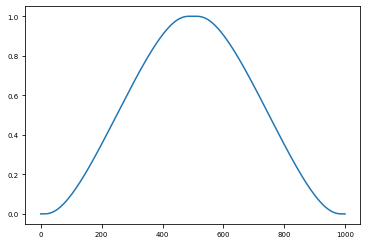

In [84]:
plt.plot(win_tanh)

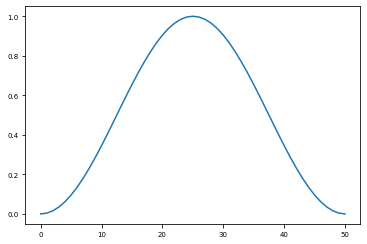

51
2048


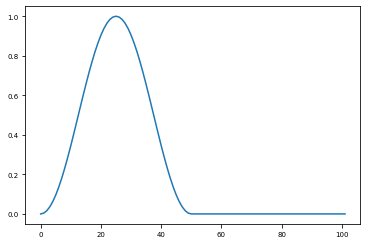

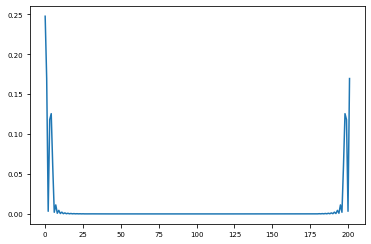

In [97]:
M = 51
hanntest = hann(M)
plt.plot(hanntest)
plt.show()

from scipy.fft import fft, fftshift

print(len(hanntest))
A = fft(hanntest, 2048) / (len(hanntest))
print(A.size)
freq = np.linspace(-0.5, 0.5, len(A))
response = np.abs(fftshift(A / abs(A).max()))

z = np.zeros(51)
hanntestfft = np.concatenate((hann(M), z))
plt.plot(hanntestfft)
plt.show()
hanntest = np.abs(np.fft.irfft(hanntestfft))
# hannfftk = np.fft.fftfreq(M) * M

plt.plot(hanntest)
# plt.plot(freq, response)
plt.show()